https://www.kaggle.com/c/mercari-price-suggestion-challenge


In [1]:
import numpy as np 
import datetime as dt
import pandas as pd 
from pandas.api.types import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv("/Users/tejaswinalwad/Machine_Learning/Kaggle_Projects/Mercari Price Suggestion Challenge/train.tsv", sep='\t')
test = pd.read_csv("/Users/tejaswinalwad/Machine_Learning/Kaggle_Projects/Mercari Price Suggestion Challenge/test.tsv", sep='\t')

In [3]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

The evaluation metric for this competition is **Root Mean Squared Logarithmic Error.**

The RMSLE is calculated as

ϵ=sqrt(1/n∑i=1(log(pi+1)−log(ai+1))**2)

Where:

ϵ is the RMSLE value (score)
n is the total number of observations in the (public/private) data set,
pi is your prediction of price, and
ai is the actual sale price for i. 
log(x) is the natural logarithm of x


In [5]:
# from sklearn.metrics import mean_squared_error
# def RMSLE(x, y): return np.sqrt(mean_squared_error(x, y)) 

def RMSLE(ypred, ytest) : 
    assert len(ytest) == len(ypred)
    return np.sqrt(np.mean((np.log1p(ypred) - np.log1p(ytest))**2))

In [6]:
from sklearn.metrics import accuracy_score
def print_score(m):
    res  = [RMSLE(y_train, m.predict(X_train)), RMSLE(y_valid, m.predict(X_valid)),
           accuracy_score(y_train, m.predict(X_train)), accuracy_score(y_valid, m.predict(X_valid))]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
train.shape, test.shape

((1482535, 8), (693359, 7))

In [8]:
pd.isnull(test).sum()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

In [9]:
pd.isnull(train).sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [11]:
train['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

In [12]:
train_data = train
train_data['name'] = train_data['name'].fillna('missing')+' '+train_data['brand_name'].fillna('missing')
train_data['info'] = train_data['category_name'].fillna('missing')+' '+train_data['item_description'].fillna('missing')

In [13]:
drop_cols = ['category_name', 'brand_name', 'item_description']
train_data.drop(drop_cols, axis=1, inplace=True)

In [14]:
test_data = test
test_data['name'] = test_data['name'].fillna('missing')+' '+test_data['brand_name'].fillna('missing')
test_data['info'] = test_data['category_name'].fillna('missing') +' '+test_data['item_description'].fillna('missing')
test_data.drop(drop_cols, axis=1, inplace=True)

In [15]:
# plt.figure(figsize=(18,10))
# sns.scatterplot(train['item_condition_id'], train['price'], hue=train['shipping'])

In [16]:
train_data['name'] = pd.to_numeric(train_data['name'], errors='coerce')
train_data['info'] = pd.to_numeric(train_data['info'], errors='coerce')

In [17]:
train_data.columns; train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 6 columns):
train_id             1482535 non-null int64
name                 0 non-null float64
item_condition_id    1482535 non-null int64
price                1482535 non-null float64
shipping             1482535 non-null int64
info                 0 non-null float64
dtypes: float64(3), int64(3)
memory usage: 67.9 MB


In [18]:
X = train_data.drop('price', axis=1)
y = train_data['price']

In [19]:
X['name'].fillna(0, inplace=True)
X['info'].fillna(0, inplace=True)

In [20]:
X.isnull().sum()

train_id             0
name                 0
item_condition_id    0
shipping             0
info                 0
dtype: int64

**Split Data**

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

**First RF on the data**

In [23]:
from sklearn.ensemble import RandomForestRegressor

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [24]:
rf = RandomForestRegressor(n_estimators=10)

In [25]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
print(cross_val_score(rf, X_train, y_train, cv=3)) 

[-0.5047262  -0.44184053 -0.47300325]


In [27]:
print(RMSLE(y_train, rf.predict(X_train)), RMSLE(y_valid, rf.predict(X_valid)))

0.43813607384760606 0.9346982564570107


In [28]:
# plt.figure(figsize=(14,10))
# sns.scatterplot(y=errors, x=X_train.shape[0])

**First XGB on the data**

In [59]:
import xgboost as xgb
clf = xgb.XGBRegressor()

In [60]:
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
print(cross_val_score(clf, X_train, y_train, cv=3)) 

[0.01193572 0.01150735 0.01136132]


In [66]:
print(RMSLE(y_train, clf.predict(X_train)), RMSLE(y_valid, clf.predict(X_valid)))

0.7994559792746087 0.7995570584357422


In [67]:
clf1 = xgb.XGBRegressor(max_depth=7, learning_rate=0.01, n_estimators=100)

In [68]:
clf1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
print(cross_val_score(clf1, X_train, y_train, cv=3))

[-0.05174515 -0.0526227  -0.05244461]


In [70]:
print(RMSLE(y_train, clf1.predict(X_train)), RMSLE(y_valid, clf1.predict(X_valid)))

0.7331737782080524 0.7347349611121103


**With Linear Regressor**

In [75]:
from sklearn.linear_model import LinearRegression
ln = LinearRegression()

In [76]:
ln.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
print(cross_val_score(ln, X_train, y_train, cv=3)) 

[0.01025568 0.00974264 0.00966561]


In [78]:
print(RMSLE(y_train, ln.predict(X_train)), RMSLE(y_valid, ln.predict(X_valid)))

0.8016878857686413 0.8016466072943323


In [42]:
train_sizes = [1, 100, 500, 2000, 5000, 8000]

In [43]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, validation_scores = learning_curve(estimator=LinearRegression(), 
                                                              X=X_train, y=y_train, cv=5, train_sizes=train_sizes,
                                                              scoring = 'neg_mean_squared_log_error')

In [27]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, validation_scores = learning_curve(estimator=RandomForestRegressor(n_estimators=5), 
                                                              X=X_train, y=y_train, cv=5, train_sizes=train_sizes,
                                                              scoring = 'neg_mean_squared_log_error')

In [44]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[-0.         -0.         -0.         -0.         -0.        ]
 [-0.3916497  -0.64528753 -0.64528753 -0.64528753 -0.64528753]
 [-0.62607065 -0.70755843 -0.70755843 -0.70755843 -0.70755843]
 [-0.64579922 -0.64044624 -0.64044624 -0.64044624 -0.64044624]
 [-0.62571373 -0.66462829 -0.66462829 -0.66462829 -0.66462829]
 [-0.63779028 -0.651317   -0.651317   -0.651317   -0.651317  ]]

 ----------------------------------------------------------------------

Validation scores:

 [[-2.77977096 -1.80532744 -1.80175741 -1.80409912 -1.80862421]
 [-0.54732548 -0.70303837 -0.70103551 -0.7023818  -0.70404479]
 [-0.62235392 -0.70435119 -0.70205326 -0.70358906 -0.70487412]
 [-0.63636606 -0.66338323 -0.6610003  -0.66271539 -0.66375777]
 [-0.6274321  -0.65985271 -0.65769404 -0.65918399 -0.66030884]
 [-0.63666076 -0.65034455 -0.64825713 -0.64967082 -0.65072674]]


In [45]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1      -0.000000
100     0.594560
500     0.691261
2000    0.641517
5000    0.656845
8000    0.648612
dtype: float64

 --------------------

Mean validation scores

 1       1.999916
100     0.671565
500     0.687444
2000    0.657445
5000    0.652894
8000    0.647132
dtype: float64


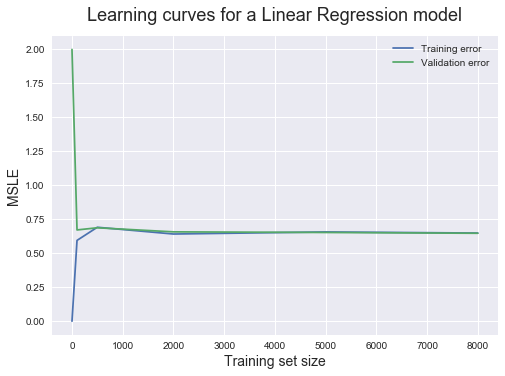

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('MSLE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Linear Regression model', fontsize = 18, y = 1.03)
plt.legend()

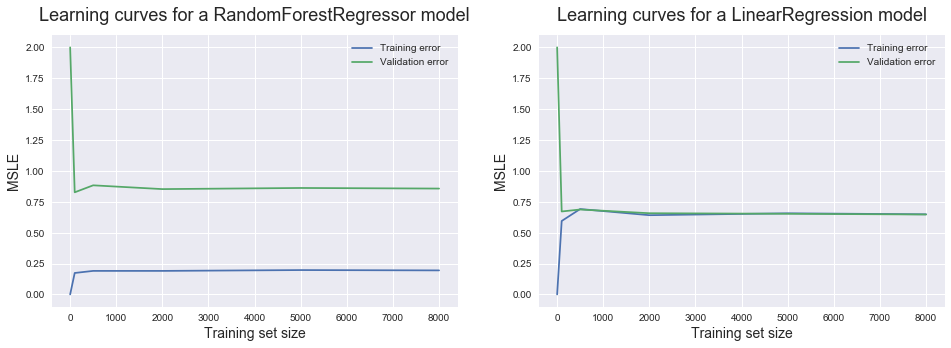

In [48]:
### Bundling our previous work into a function ###

def learning_curves(estimator, X_train, y_train, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, X_train, y_train, train_sizes = train_sizes,
                                                 cv = cv, scoring = 'neg_mean_squared_log_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSLE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()


### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestRegressor

plt.figure(figsize = (16,5))

for model, i in [(RandomForestRegressor(), 1), (LinearRegression(),2)]:
    plt.subplot(1,2,i)
    learning_curves(model, X_train, y_train, train_sizes, 5)